<a href="https://colab.research.google.com/github/ssv273/Neural_Univesity/blob/main/hw_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Возьмите базу трафика с сайта компании. Напишите модель для прогнозирования трафика. 

Возьмите xLen = 60. Добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [57]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras.utils import to_categorical 
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

import warnings
warnings.filterwarnings("ignore")
# Рисовать графики сразу же
%matplotlib inline

In [58]:
data = pd.read_csv("/content/drive/MyDrive/Neural_Univesity/traff.csv", header=None)
data.head()

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"


In [59]:
data.columns = ['Date', 'value']

In [60]:
data['Date'] = pd.to_datetime(data['Date'])
data['value'] = data['value'].str.replace(',', '').astype('float32')

In [61]:
data.head(2)

,Date,value
0,2017-01-01,22226.0
1,2017-01-02,29593.0


In [62]:
data.shape

(1095, 2)

посмотрим на график трафика

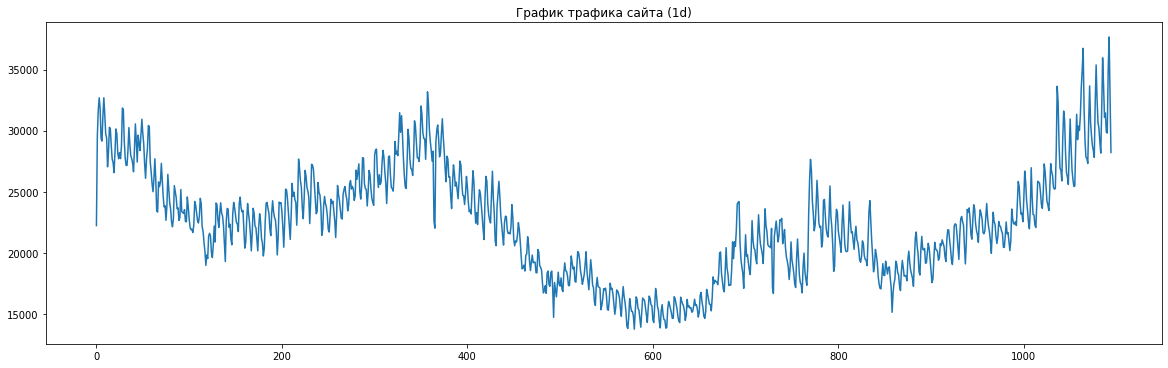

In [63]:
plt.figure(figsize=(20,8))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
data['value'].plot(ax = ax0)
plt.title('График трафика сайта (1d)')
plt.show()

In [64]:
#Формируем параметры загрузки данных

xLen = 60                      #Анализируем по 60 прошедшим точкам 
valLen = 200                  #Используем 200 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen]['value'].values, data[trainLen+xLen+2:]['value'].values

#Масштабируем данные 
xScaler = MinMaxScaler()
xScaler.fit(xTrain.reshape(-1, 1))
xTrain = xScaler.transform(xTrain.reshape(-1, 1))
xTest = xScaler.transform(xTest.reshape(-1, 1))

yTrain, yTest = xTrain, xTest

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [65]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 60, 1) (20, 1)


In [66]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [67]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=60, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

# Dense

In [68]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,1), activation="relu" ))
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelD.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 60, 150)           300       
_________________________________________________________________
flatten_7 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9001      
Total params: 9,301
Trainable params: 9,301
Non-trainable params: 0
_________________________________________________________________


In [69]:
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=150, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/150
42/42 [==============================] - 1s 7ms/step - loss: 0.0400 - val_loss: 0.0433
Epoch 2/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.0543
Epoch 3/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0449
Epoch 4/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0396
Epoch 5/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0381
Epoch 6/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0402
Epoch 7/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0336
Epoch 8/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0437
Epoch 9/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0411
Epoch 10/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0346
Epoch 11/

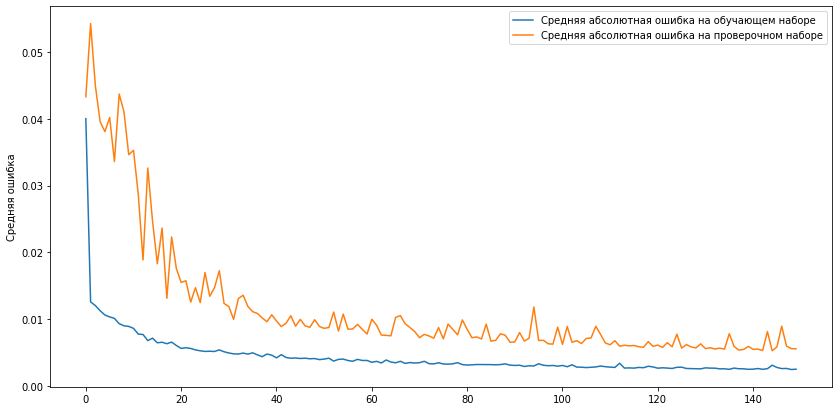

In [70]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [71]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-6))
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=150, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/150
42/42 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 2/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 3/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 4/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 5/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 6/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 7/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 8/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 9/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 10/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 11/

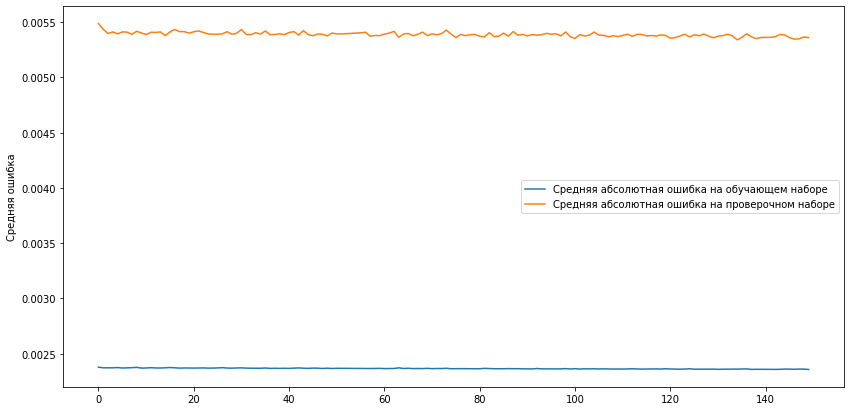

In [72]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

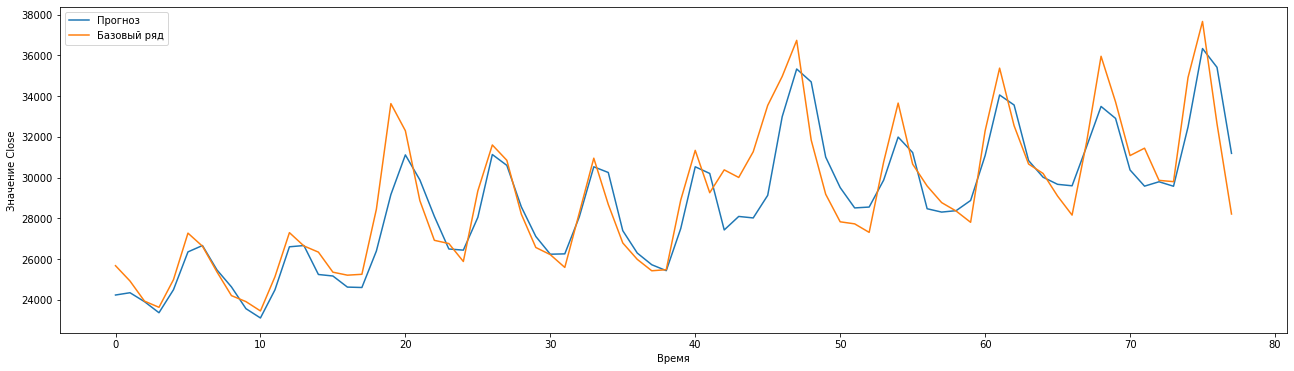

In [73]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], xScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, data.shape[0], 0, predVal, yValUnscaled)


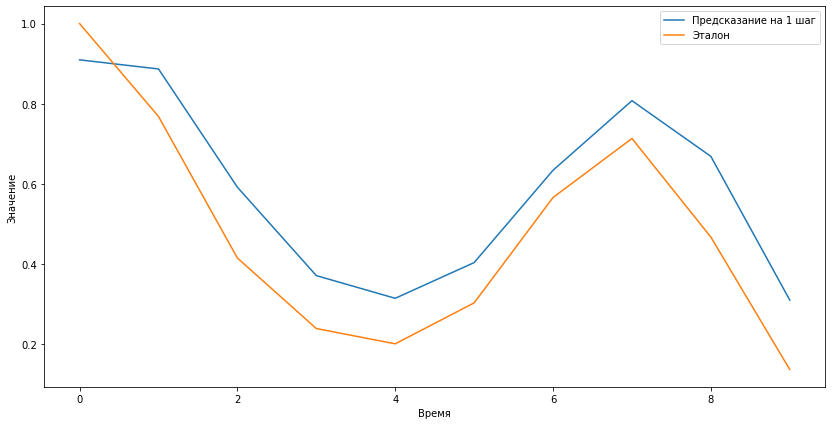

In [74]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

# Conv

In [75]:
modelC = Sequential()

modelC.add(Conv1D(64, 5, input_shape = (xLen,1), activation="relu"))
modelC.add(Conv1D(64, 5, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(100, activation="relu"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 56, 64)            384       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 52, 64)            20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 26, 64)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               166500    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 187,529
Trainable params: 187,529
Non-trainable params: 0
________________________________________________

In [76]:
history = modelC.fit(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/50
42/42 [==============================] - 1s 8ms/step - loss: 0.0396 - val_loss: 0.0684
Epoch 2/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0330
Epoch 3/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0385
Epoch 4/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0172
Epoch 5/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0104 - val_loss: 0.0312
Epoch 6/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0263
Epoch 7/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0256
Epoch 8/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0393
Epoch 9/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0486
Epoch 10/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0080 - val_loss: 0.0215
Epoch 11/50
42/42 [

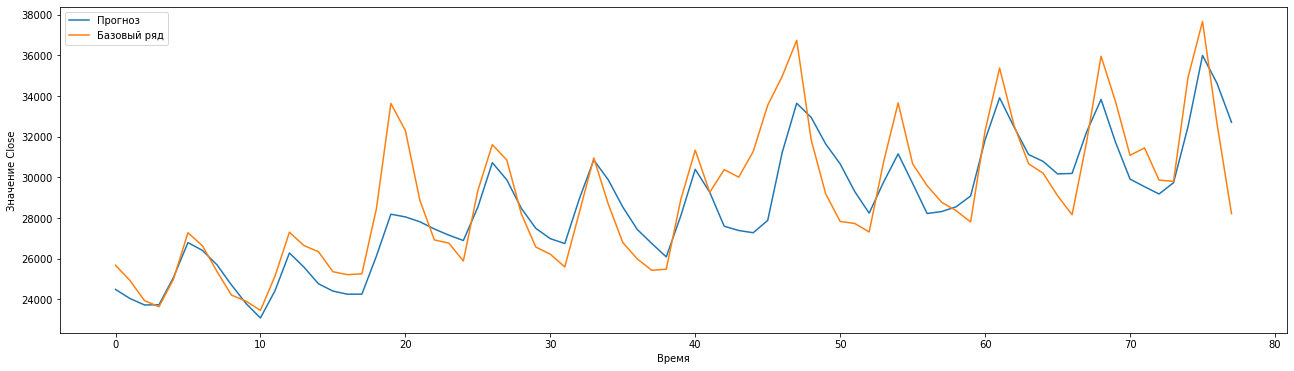

In [77]:
#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], xScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, data.shape[0], 0, predVal, yValUnscaled)


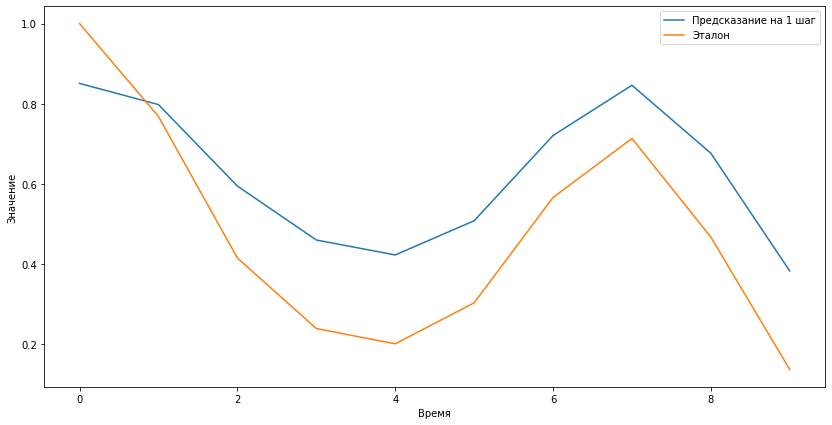

In [78]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

# LSTM

In [79]:
import tensorflow
modelL = Sequential()
modelL.add(LSTM(5, input_shape = (xLen, 1)))
modelL.add(Dense(10, activation="relu"))
modelL.add(Dense(1, activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-3))

modelL.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = modelL.fit(trainDataGen, 
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/50
42/42 [==============================] - 3s 23ms/step - loss: 0.1446 - val_loss: 0.3438
Epoch 2/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0394 - val_loss: 0.1446
Epoch 3/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0165 - val_loss: 0.0852
Epoch 4/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0119 - val_loss: 0.0598
Epoch 5/50
42/42 [==============================] - 1s 13ms/step - loss: 0.0095 - val_loss: 0.0475
Epoch 6/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0077 - val_loss: 0.0409
Epoch 7/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0069 - val_loss: 0.0323
Epoch 8/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0064 - val_loss: 0.0322
Epoch 9/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0278
Epoch 10/50
42/42 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0296
Epoch 11/

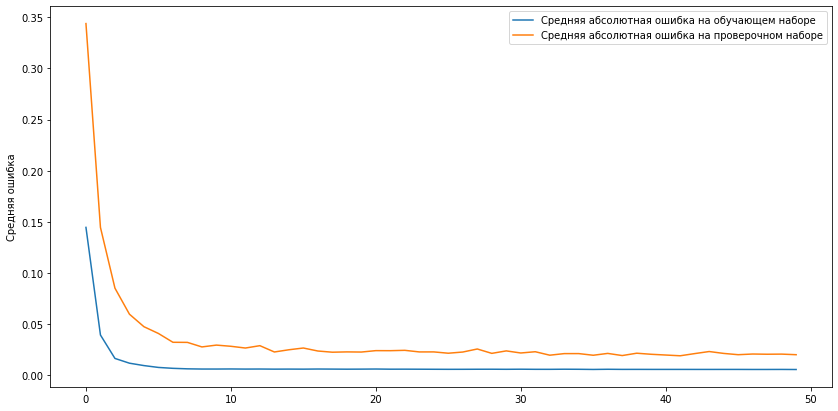

In [81]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [82]:
modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

In [83]:
history = modelL.fit(trainDataGen, 
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/50
42/42 [==============================] - 3s 23ms/step - loss: 0.0056 - val_loss: 0.0202
Epoch 2/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0057 - val_loss: 0.0202
Epoch 3/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0203
Epoch 4/50
42/42 [==============================] - 1s 13ms/step - loss: 0.0056 - val_loss: 0.0202
Epoch 5/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0202
Epoch 6/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0202
Epoch 7/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0202
Epoch 8/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0202
Epoch 9/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0202
Epoch 10/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0201
Epoch 11/

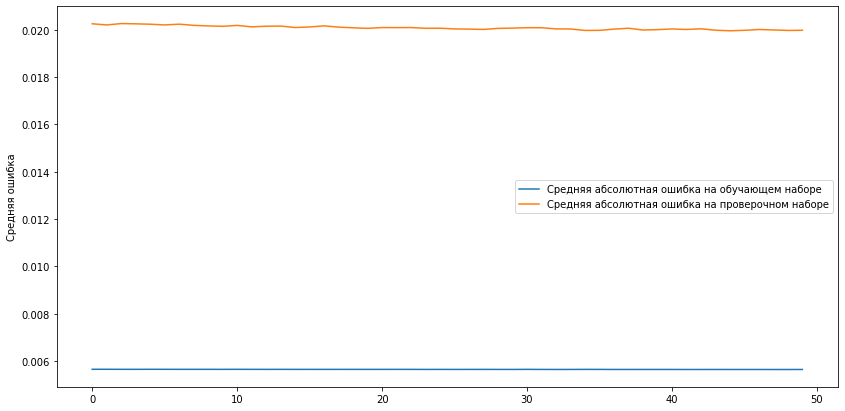

In [84]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

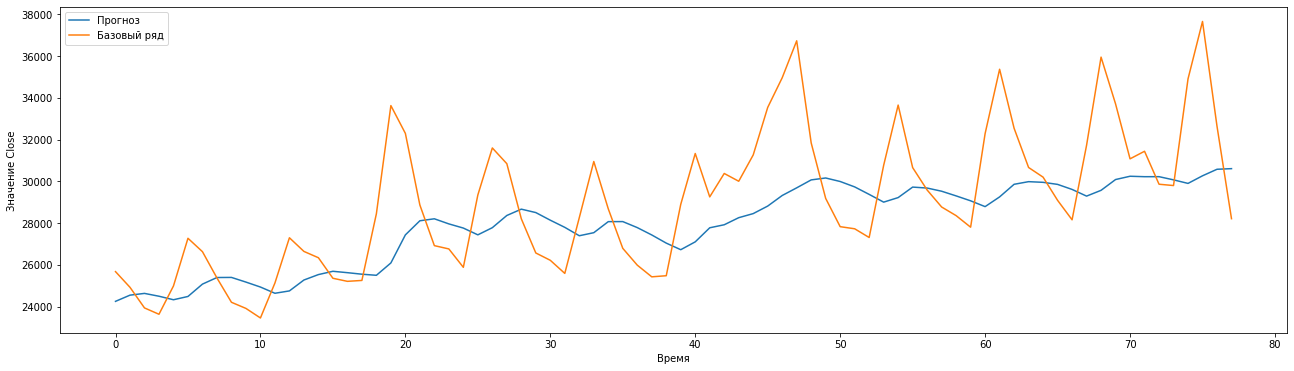

In [85]:
#Прогнозируем данные текущей сетью
currModel = modelL #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], xScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, data.shape[0], 0, predVal, yValUnscaled)


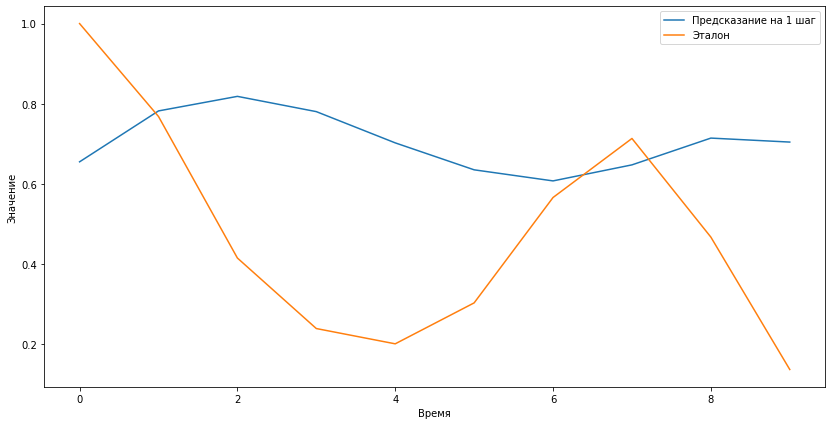

In [86]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

# RES

усложним первую модель и посмотрим на результат

In [96]:
#Создаём нейронку
model = Sequential()
model.add(Dense(256,input_shape = (xLen,1), activation="relu" ))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu" ))
model.add(Flatten())
model.add(Dense(1, activation="linear"))

#Компилируем
model.compile(loss="mse", optimizer=Adam(lr=1e-4))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 60, 256)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
dense_29 (Dense)             (None, 60, 128)           32896     
_________________________________________________________________
flatten_12 (Flatten)         (None, 7680)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 7681      
Total params: 41,089
Trainable params: 41,089
Non-trainable params: 0
_________________________________________________________________


In [97]:
#Запускаем обучение
history = model.fit(
                    trainDataGen, 
                    epochs=150, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/150
42/42 [==============================] - 1s 9ms/step - loss: 0.0724 - val_loss: 0.0895
Epoch 2/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0878
Epoch 3/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.1084
Epoch 4/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0843
Epoch 5/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0665
Epoch 6/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0754
Epoch 7/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.0941
Epoch 8/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0833
Epoch 9/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0643
Epoch 10/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0816
Epoch 11/

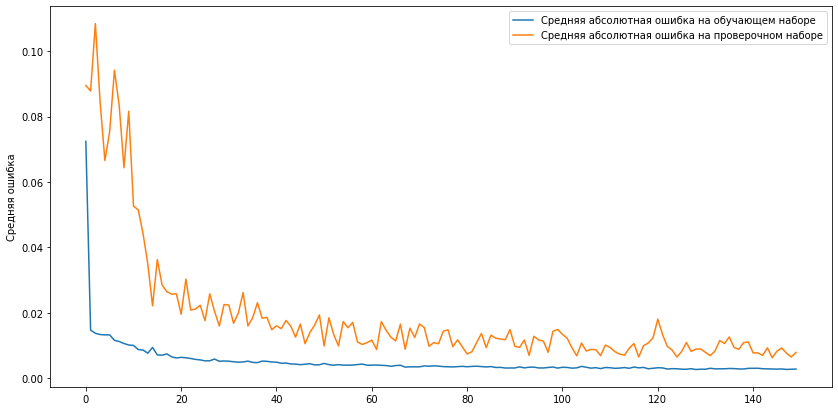

In [98]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [99]:
#Компилируем
model.compile(loss="mse", optimizer=Adam(lr=1e-6))
#Запускаем обучение
history = model.fit(
                    trainDataGen, 
                    epochs=150, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/150
42/42 [==============================] - 1s 18ms/step - loss: 0.0024 - val_loss: 0.0078
Epoch 2/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 3/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 4/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 5/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 6/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 7/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 8/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 9/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 10/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 11

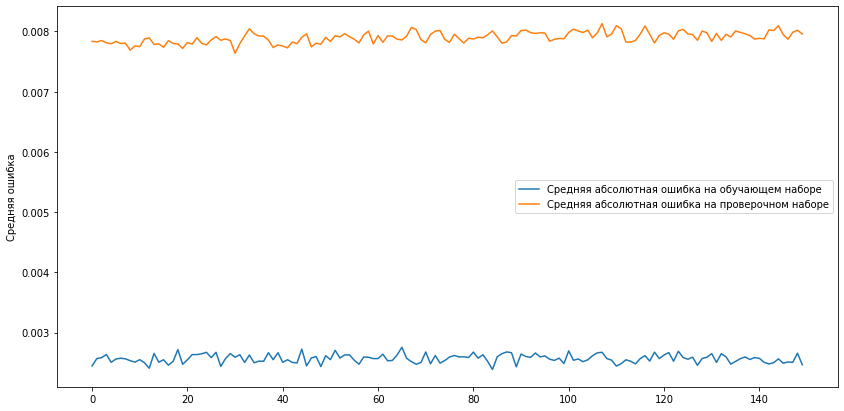

In [100]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

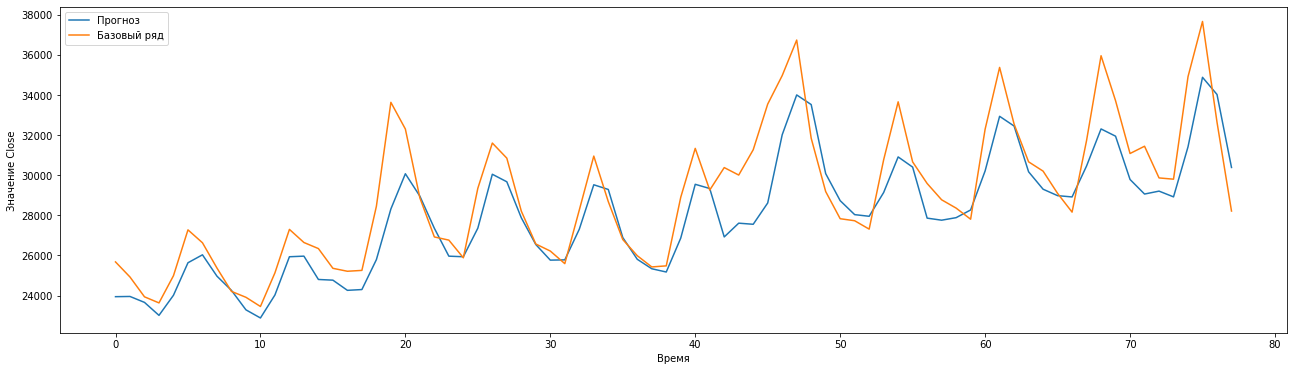

In [101]:
#Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], xScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, data.shape[0], 0, predVal, yValUnscaled)


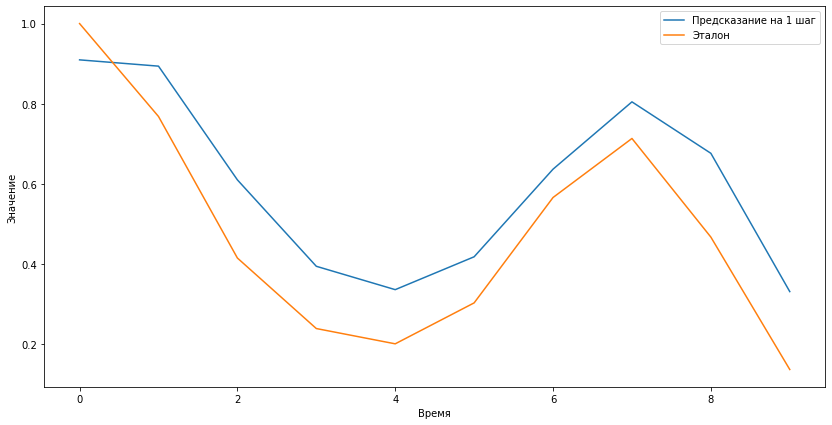

In [102]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

пока это лучшее, чего удалось добиться